# Fine-Tune a SciBERT Model
### Load queried data

In [7]:
import pandas as pd
import torch
import numpy as np
from transformers import AutoModel, AutoTokenizer
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import os

In [8]:
MAX_LEN = 512
TRAIN_BATCH_SIZE = 4
VAL_BATCH_SIZE = 4
TEST_BATCH_SIZE = 4
EPOCHS = 2
LEARNING_RATE = 1e-5
RANDOM_SEED = 42
MODEL_NAME = "allenai/scibert_scivocab_uncased"
CLASSES = ["human", "veterinary"]
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

In [9]:
import itertools
from xml.etree.ElementTree import ElementTree
import pandas as pd


# Extract data from XML and create a DataFrame
xml_files = [["NEJM_data.xml", "BMJ_data.xml"], ["animals_data.xml", "caserepvetmed_data.xml", "jvetmedsci_data.xml", "frontvetsci_data.xml", "jamanimhospassoc_data.xml", "jsmallanimpract_data.xml", "openvetj_data.xml", "vetmedsci_data.xml", "vetsci_data.xml"]]
data_path = "../data-querying/results/"

data_sets = [[], []]
record_sets = []
tree = ElementTree()

for i, med_field in enumerate(xml_files):
    med_field_lists = []
    for xml in med_field:
        temp = tree.parse(data_path + xml)
        med_field_lists.append(temp.findall('.//Rec'))
    record_sets.append(list(itertools.chain(*med_field_lists)))

progress_bar = tqdm(range(sum(len(x) for x in record_sets)))

for i, med_field in enumerate(CLASSES):
    print(f"Processing {xml_files[i]}")
    labels = [1,0] if med_field == "human" else [0,1]
    for rec in record_sets[i]:
        try: 
            common = rec.find('.//Common')
            pmid = common.find('PMID').text
            text_types = [elem.text for elem in common.findall('Type')]
            title = common.find('Title').text
            abstract = common.find('Abstract').text
            mesh_term_list = rec.find('.//MeshTermList')
            mesh_terms = [term.text for term in mesh_term_list.findall('MeshTerm')]
        except Exception as e:
            print(f"An error occurred: {e}")
            print(f"Error occured for PMID: {pmid}")

        data_sets[i].append({'pmid': pmid, "text_types": text_types, 'title': title,
                    'abstract': abstract, 'meshtermlist': mesh_terms, 'labels': labels})
        progress_bar.update(1)

hum_df = pd.DataFrame(data_sets[0])
vet_df = pd.DataFrame(data_sets[1])

100%|██████████| 74757/74757 [13:34<00:00, 91.74it/s]   


Processing ['NEJM_data.xml', 'BMJ_data.xml']


Processing ['animals_data.xml', 'caserepvetmed_data.xml', 'jvetmedsci_data.xml', 'frontvetsci_data.xml', 'jamanimhospassoc_data.xml', 'jsmallanimpract_data.xml', 'openvetj_data.xml', 'vetmedsci_data.xml', 'vetsci_data.xml']


In [10]:
hum_df.describe()

,pmid,text_types,title,abstract,meshtermlist,labels
count,34040,34040,34040,34040,34040,34040
unique,34040,637,34016,34032,32915,1
top,616,"[Case Reports, Journal Article]","""Medicalized"" sex.","A young, previously well primigravida presente...",[],"[1, 0]"
freq,1,20274,3,2,1117,34040


In [11]:
vet_df.describe()

,pmid,text_types,title,abstract,meshtermlist,labels
count,40717,40717,40717,40717,40717,40717
unique,40717,162,40708,40672,14995,1
top,25126422,[Journal Article],Corrigendum: Progress With Livestock Welfare i...,In the original publication [...].,[],"[0, 1]"
freq,1,28317,2,10,25717,40717


In [12]:
hum_df[hum_df['text_types'].apply(lambda x: "Congress" in x)]

,pmid,text_types,title,abstract,meshtermlist,labels
3310,6104293,"[Congress, Research Support, U.S. Gov't, P.H.S.]",Occupational rituals in patient management.,The social practices surrounding diagnosis and...,"[Clinical Competence, Congresses as Topic, Dec...","[1, 0]"
3312,6104296,"[Bibliography, Congress]",Fate of cardiology research originally publish...,A computerized search of 276 randomly selected...,"[Abstracting and Indexing, Bibliographies as T...","[1, 0]"


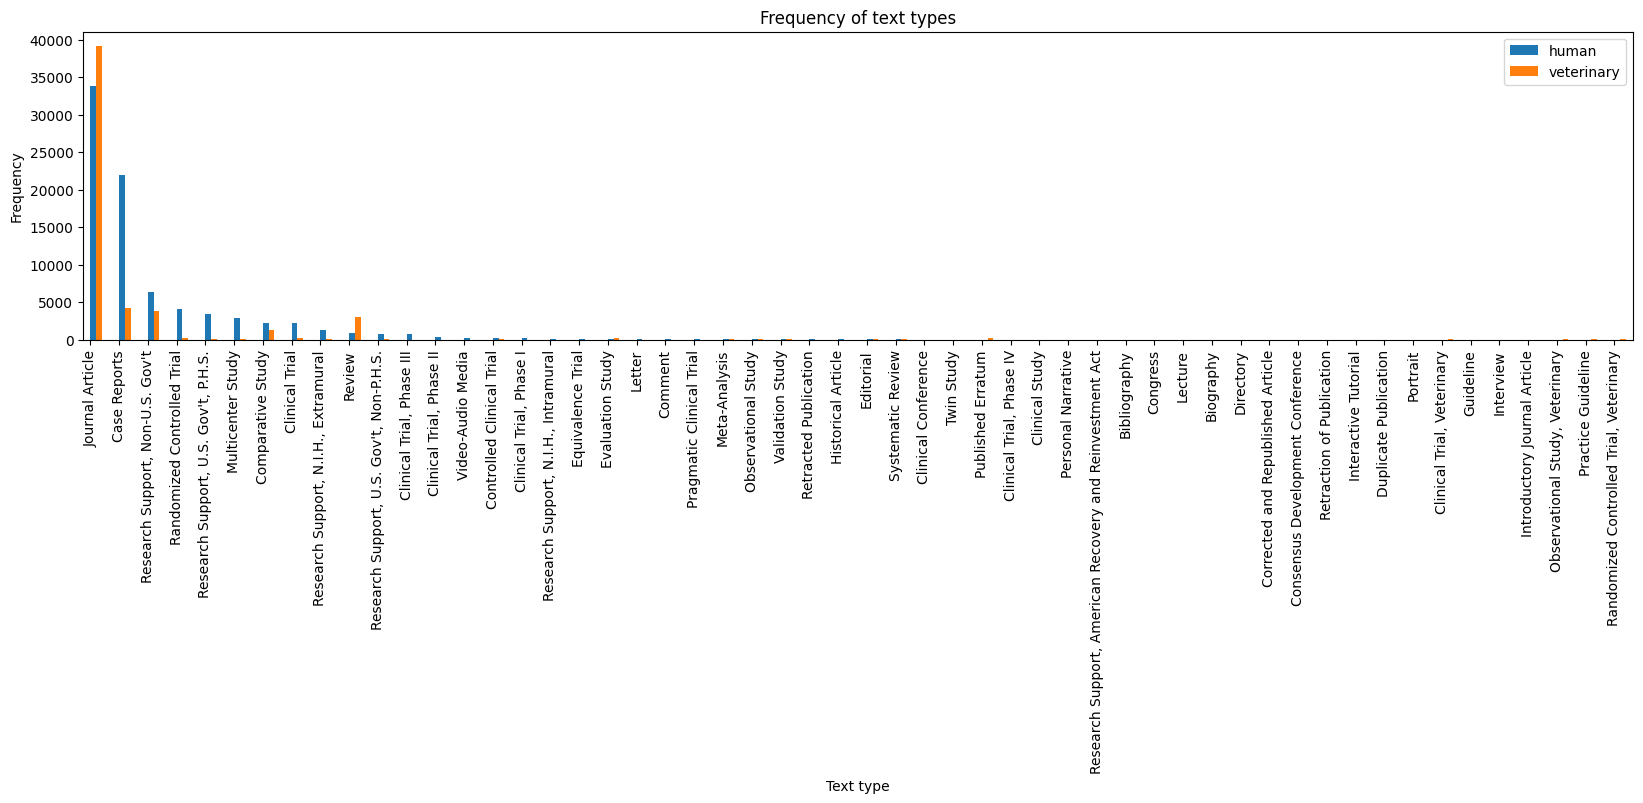

In [13]:
hum_exploded_df = hum_df.explode("text_types")
vet_exploded_df = vet_df.explode("text_types")

hum_text_type_counts = hum_exploded_df['text_types'].value_counts()
vet_text_type_counts = vet_exploded_df['text_types'].value_counts()

hum_test_type_counts_aligned, vet_test_type_counts_aligned = hum_text_type_counts.align(vet_text_type_counts, join='outer')
test_type_counts_aligned = pd.concat([hum_test_type_counts_aligned.sort_values(ascending=False), 
                                      vet_test_type_counts_aligned.sort_values(ascending=False)], 
                                     keys=['human', 'veterinary'], 
                                     axis=1)

test_type_counts_aligned.plot(kind='bar', position=0, width=0.4, figsize=(20, 4))

plt.title('Frequency of text types')
plt.xlabel('Text type')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [14]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
device

'cuda'

In [15]:
class Dataset(Dataset):

    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        text = str(self.texts[idx])
        labels = self.labels[idx]

        encodings = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            truncation=True,
            pad_to_max_length=True,
            return_token_type_ids=True,
            return_attention_mask=True,
            return_tensors="pt"
        )
        
        ids = encodings['input_ids'].flatten()
        mask = encodings['attention_mask'].flatten()
        token_type_ids = encodings["token_type_ids"].flatten()


        return {
            'text': text,
            'input_ids': ids.to(device),
            'attention_mask': mask.to(device),
            'token_type_ids': token_type_ids.to(device),
            'labels': torch.tensor(labels, dtype=torch.long).to(device)
        }

In [16]:
num_objects = 100
hum_df = hum_df.sample(num_objects, random_state=42).reset_index(drop=True, inplace=False)
vet_df = vet_df.sample(num_objects, random_state=42).reset_index(drop=True, inplace=False)

In [17]:
from sklearn.model_selection import train_test_split


hum_train_set, hum_test_set = train_test_split(
  hum_df,
  test_size=0.1,
  random_state=RANDOM_SEED
)

hum_train_set, hum_val_set = train_test_split(
  hum_train_set,
  test_size=0.2,
  random_state=RANDOM_SEED
)

vet_train_set, vet_test_set = train_test_split(
  vet_df,
  test_size=0.1,
  random_state=RANDOM_SEED
)

vet_train_set, vet_val_set = train_test_split(
  vet_train_set,
  test_size=0.2,
  random_state=RANDOM_SEED
)

train_set = pd.concat([hum_train_set, vet_train_set]).sample(frac=1).reset_index(drop=True, inplace=False)
val_set = pd.concat([hum_val_set, vet_val_set]).sample(frac=1).reset_index(drop=True, inplace=False)
test_set = pd.concat([hum_test_set, vet_test_set]).sample(frac=1).reset_index(drop=True, inplace=False)

print("TRAIN Dataset: {}".format(train_set.shape))
print("VAL Dataset: {}".format(val_set.shape))
print("TEST Dataset: {}".format(test_set.shape))

TRAIN Dataset: (144, 6)
VAL Dataset: (36, 6)
TEST Dataset: (20, 6)


In [18]:
train_set

,pmid,text_types,title,abstract,meshtermlist,labels
0,31618560,"[Comparative Study, Journal Article, Multicent...","Six-Month Randomized, Multicenter Trial of Clo...",Closed-loop systems that automate insulin deli...,"[Adolescent, Adult, Aged, Blood Glucose, Diabe...","[1, 0]"
1,30813613,[Journal Article],Health and Body Conditions of Riding School Ho...,We compared welfare measures of horses among S...,[],"[0, 1]"
2,10528034,"[Comparative Study, Journal Article, Research ...",A 10-year prospective study of primary hyperpa...,"In the United States, most patients with prima...","[Adult, Aged, Bone Density, Calcium, Disease P...","[1, 0]"
3,12655114,[Journal Article],Bovine apolipoprotein E in plasma: increase of...,Apolipoprotein E (apoE) is a protein constitue...,"[Animals, Apolipoproteins E, Cattle, Fasting, ...","[0, 1]"
4,23220825,"[Case Reports, Journal Article]",Longevity and Patau syndrome: what determines ...,The authors report of an 8-year-old girl with ...,"[Child, Chromosome Disorders, Chromosomes, Hum...","[1, 0]"
...,...,...,...,...,...,...
139,12878742,"[Clinical Trial, Journal Article, Randomized C...",Epidermal growth factor enemas with oral mesal...,Epidermal growth factor (EGF) is a potent mito...,"[Administration, Oral, Adult, Anti-Inflammator...","[1, 0]"
140,8912244,"[Case Reports, Journal Article]",Triple pelvic osteotomy for the treatment of p...,A mature female domestic shorthaired cat with ...,"[Animals, Bone Diseases, Cat Diseases, Cats, F...","[0, 1]"
141,33952564,"[Case Reports, Journal Article]",Severe amnestic syndrome due to theophylline t...,We report a case of severe amnestic syndrome f...,"[Encephalitis, Female, Hashimoto Disease, Huma...","[1, 0]"
142,27152315,[Journal Article],Sentinel Animals in a One Health Approach to H...,"People, domestic animals, and wildlife are all...",[],"[0, 1]"


In [19]:
def get_dataloader(texts, targets, tokenizer, batch_size, max_len, num_workers=0):
    dataset = Dataset(texts.to_numpy(), targets, tokenizer, max_len)
    params = {
        "batch_size":batch_size,
        "num_workers":num_workers
    }
    dataloader = DataLoader(dataset, **params)
    
    return dataloader

In [20]:
train_set["title_abstract"] = train_set[["title", "abstract"]].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
val_set["title_abstract"] = val_set[["title", "abstract"]].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
test_set["title_abstract"] = test_set[["title", "abstract"]].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)

In [21]:
train_dataloader = get_dataloader(train_set.abstract, train_set.labels, tokenizer, TRAIN_BATCH_SIZE, MAX_LEN)
val_dataloader = get_dataloader(val_set.abstract, val_set.labels, tokenizer, VAL_BATCH_SIZE, MAX_LEN)
test_dataloader = get_dataloader(test_set.abstract, test_set.labels, tokenizer, TEST_BATCH_SIZE, MAX_LEN)

In [22]:
class SciBertClassifier(torch.nn.Module):

    def __init__(self, dropout=0.5):

        super(SciBertClassifier, self).__init__()

        self.scibert =AutoModel.from_pretrained(MODEL_NAME, num_labels=2)
        self.dropout = torch.nn.Dropout(dropout)
        self.linear = torch.nn.Linear(self.scibert.config.hidden_size, 2)

    def forward(self, input_ids, attention_mask, token_type_ids):

        scibert_output = self.scibert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids = token_type_ids)
        dropout_output = self.dropout(scibert_output[1])
        output = self.linear(dropout_output)

        return output

In [23]:
model = SciBertClassifier()
model = model.to(device)

In [24]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

In [25]:
from transformers import get_linear_schedule_with_warmup

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
total_steps = len(train_dataloader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

In [26]:
def eval_model(model, dataloader, loss_fn, device):
    model = model.eval()
    
    loss = 0.0
    correct_predictions = 0.0
    
    with torch.no_grad():
        for data in dataloader:
            input_ids = data["input_ids"].to(device, dtype = torch.long)
            attention_mask = data["attention_mask"].to(device, dtype = torch.long)
            token_type_ids = data["token_type_ids"].to(device, dtype = torch.long)
            labels = data["labels"].to(device, dtype = torch.float)
            
            outputs = model(input_ids, attention_mask, token_type_ids)
            loss += loss_fn(outputs, labels).item()
            
            preds = torch.argmax(outputs, dim=1)
            correct_predictions += torch.sum(preds == torch.argmax(labels, dim=1)).item()
            
            
    num_data = len(dataloader) * VAL_BATCH_SIZE
    return correct_predictions / num_data, loss / num_data

In [33]:
from tqdm import tqdm

def train_model(model, train_dataloader, val_dataloader, loss_fn, optimizer, device, scheduler, epochs):
    progress_bar = tqdm(range(len(train_dataloader) * epochs))
    model = model.train()
    history = []
    best_acc = 0
    
    for epoch_num in range(epochs):
        print("_" * 30)
        print(f'Epoch {epoch_num} started.')
        
        total_loss = 0
        correct_predictions = 0.0
        
        for data in train_dataloader:
            input_ids = data['input_ids'].to(device, dtype = torch.long)
            attention_mask = data['attention_mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            labels = data['labels'].to(device, dtype = torch.float)

            outputs = model(input_ids, attention_mask, token_type_ids)
            preds = torch.argmax(outputs, dim=1)
            correct_predictions += torch.sum(preds == torch.argmax(labels, dim=1)).item()
            
            loss = loss_fn(outputs, labels)
            total_loss += loss.item()
            
            
            loss.backward()
            # to avoid exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
                        
            progress_bar.update(1)
        
        num_data = len(train_dataloader) * TRAIN_BATCH_SIZE
        train_acc = correct_predictions / num_data
        train_loss = total_loss / num_data
        print(f'Epoch: {epoch_num}, Train Accuracy {train_acc}, Loss:  {train_loss}')

        val_acc, val_loss = eval_model(model, val_dataloader, loss_fn, device)
        print(f'Epoch: {epoch_num}, Validation Accuracy {val_acc}, Loss:  {val_loss}')
        
        history.append({"train_acc": train_acc, "train_loss": train_loss, "val_acc": val_acc, "val_loss": val_loss})
        
        if val_acc > best_acc:
            torch.save(model.state_dict(), 'best_model.bin')
            best_acc = val_acc
            
    return history

In [34]:
train = True

work_dir = "./"
model_filename = "best_model.bin"
filenames = os.listdir(work_dir)

if model_filename in filenames and not train:
    model = SciBertClassifier()
    model.load_state_dict(torch.load(work_dir + model_filename))
    model.to(device)
    print(f"{model_filename} loaded.")
else:
    print("No saved model found or forced to train.")

    torch.cuda.empty_cache()
    history = train_model(model, train_dataloader, val_dataloader, loss_fn, optimizer, device, scheduler, EPOCHS)

No saved model found or forced to train.


  0%|          | 0/72 [00:00<?, ?it/s]

______________________________
Epoch 0 started.


c:\Users\albbl\Documents\Studium\11_Semester\medtextclassification_repo\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
 50%|█████     | 36/72 [15:32<15:54, 26.52s/it]

Epoch: 0, Train Accuracy 0.75, Loss:  0.1471985454360644
Epoch: 0, Validation Accuracy 0.8611111111111112, Loss:  0.12762302574184206
______________________________
Epoch 1 started.


100%|██████████| 72/72 [28:22<00:00, 21.34s/it]

Epoch: 1, Train Accuracy 0.9375, Loss:  0.09172083613359266
Epoch: 1, Validation Accuracy 0.9166666666666666, Loss:  0.09603150023354425


100%|██████████| 72/72 [29:07<00:00, 24.27s/it]


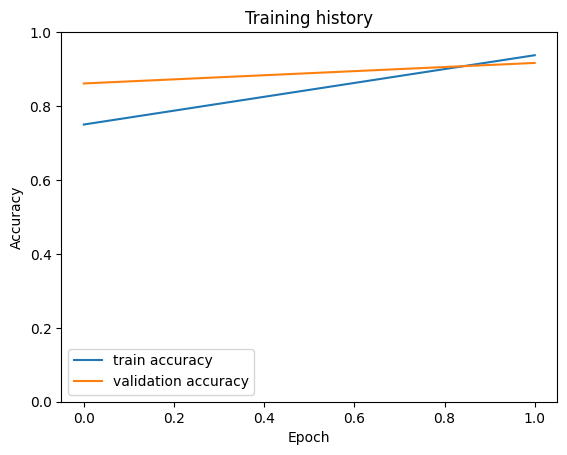

In [35]:
if history:
    history = pd.DataFrame(history)

    plt.plot(history['train_acc'], label='train accuracy')
    plt.plot(history['val_acc'], label='validation accuracy')
    plt.title('Training history')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.ylim([0, 1])

In [36]:
def predict(model, texts, tokenizer, max_len=512):
    progress_bar = tqdm(range(len(texts)))

    predictions = []
    for data in texts:
        text = str(data)

        inputs = tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=max_len,
            pad_to_max_length=True,
            return_token_type_ids=True
        )
        ids = torch.tensor(inputs['input_ids'], dtype=torch.long).unsqueeze(0).to(device)
        mask = torch.tensor(inputs['attention_mask'], dtype=torch.long).unsqueeze(0).to(device)
        token_type_ids = torch.tensor(inputs["token_type_ids"], dtype=torch.long).unsqueeze(0).to(device)

        with torch.no_grad():
            logits = model(ids, mask, token_type_ids)
        
        probabilities = torch.sigmoid(logits.squeeze())
        predictions.append(probabilities)

        
        progress_bar.update(1)

    return predictions

In [37]:
acc, loss = eval_model(model, test_dataloader, loss_fn, device)
print(f"TEST dataset - Accuracy: {acc}, Loss: {loss}")

TEST dataset - Accuracy: 0.9, Loss: 0.09643425047397614


In [38]:
text = ["All animal procedures conformed with the Regulations for the Administration of Affairs Concerning Experimental Animals (Ministry of Science and Technology, Beijing, China, 2004) and were approved by the Institutional Animal Care and Use Committee (College of Animal Science and Technology, Northwest A&F University, Yanling, Xianyang, China, No. 2013-23, 20 April 2013). In this study, the 4-day-old Qinchuan beef cattle was used to isolate preadipocytes and myoblasts, and the cattle was born and raised at the breeding farm of the National Beef Cattle Improvement Center (Yangling, Xianyang, China)."]
predict(model, text, tokenizer)

  0%|          | 0/1 [00:00<?, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


100%|██████████| 1/1 [00:00<00:00,  1.68it/s]


[tensor([0.3845, 0.5748], device='cuda:0')]

In [39]:
test_preds = predict(model, test_set.title_abstract, tokenizer)
test_preds

100%|██████████| 20/20 [00:10<00:00,  1.95it/s]


[tensor([0.7821, 0.2963], device='cuda:0'),
 tensor([0.1885, 0.8267], device='cuda:0'),
 tensor([0.7076, 0.3069], device='cuda:0'),
 tensor([0.7532, 0.2914], device='cuda:0'),
 tensor([0.3438, 0.6527], device='cuda:0'),
 tensor([0.6884, 0.3242], device='cuda:0'),
 tensor([0.1833, 0.8372], device='cuda:0'),
 tensor([0.5314, 0.4455], device='cuda:0'),
 tensor([0.1998, 0.8691], device='cuda:0'),
 tensor([0.7971, 0.2453], device='cuda:0'),
 tensor([0.6840, 0.3438], device='cuda:0'),
 tensor([0.1826, 0.8392], device='cuda:0'),
 tensor([0.4051, 0.5310], device='cuda:0'),
 tensor([0.2031, 0.8009], device='cuda:0'),
 tensor([0.7206, 0.3329], device='cuda:0'),
 tensor([0.1877, 0.8374], device='cuda:0'),
 tensor([0.6683, 0.3986], device='cuda:0'),
 tensor([0.8277, 0.2265], device='cuda:0'),
 tensor([0.7294, 0.2958], device='cuda:0'),
 tensor([0.7169, 0.3696], device='cuda:0')]

In [40]:
test_labels = [labels.index(max(labels)) for labels in test_set.labels]
preds_labels = [torch.argmax(pred).item() for pred in test_preds]
test_labels

[0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0]

In [41]:
from sklearn.metrics import classification_report
classes = ["human", "veterinary"]

report = classification_report(test_labels, preds_labels, target_names=classes)
print(report)

              precision    recall  f1-score   support

       human       0.83      1.00      0.91        10
  veterinary       1.00      0.80      0.89        10

    accuracy                           0.90        20
   macro avg       0.92      0.90      0.90        20
weighted avg       0.92      0.90      0.90        20



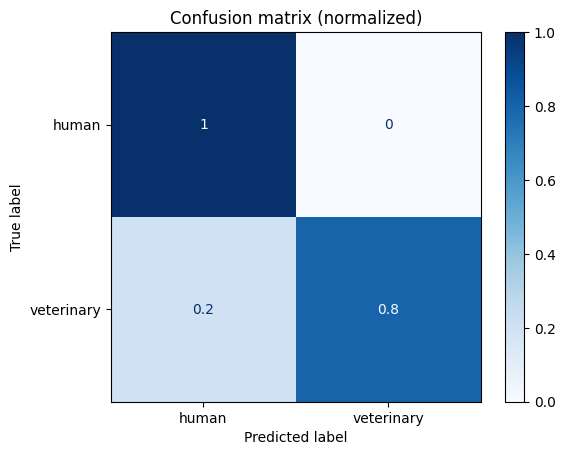

In [42]:
from sklearn.metrics import ConfusionMatrixDisplay

test_classes = ["human" if label == 0 else "veterinary" for label in test_labels]
preds_classes = ["human" if label == 0 else "veterinary" for label in preds_labels]
disp = ConfusionMatrixDisplay.from_predictions(test_classes, preds_classes, labels=classes, normalize="true", cmap=plt.cm.Blues)
disp.ax_.set_title("Confusion matrix (normalized)")
plt.show()